In [2]:
# %reset -f

import sys
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

# install custom package with: pip install git+https://github.com/owenodriscoll/AutoML.git
sys.path.insert(0, os.path.abspath('..'))  # hacky way to import within package
from AutoML import AutomatedRegression
from importlib import reload
import AutoML; reload(AutoML); from AutoML.misc import outlier_detector, plot_envelope_single
# from AutoML.misc import outlier_detector, plot_envelope_single

/Users/opodriscoll/miniconda3/envs/env_AutoML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#%% load data

data_dir = '/Users/opodriscoll/Documents/Data/'
df_rolls = pd.read_csv(f'{data_dir}df_rolls.csv')
df_cells = pd.read_csv(f'{data_dir}df_cells.csv')

df = pd.concat([df_cells, df_rolls]) 

In [4]:
#%% filtering of estimates 

# -- conditions for filtering
window_effect_threshhold_low = 0.5
window_effect_threshhold_high = 1.5
S_windfield_xi_norm_std_threshhold = 0.25
inertial_subrange_length_fraction_threshold = 0.2 
inertial_subrange_length_threshold = 200 # m
peak_max_threshold = 2950
peak_min_threshold = 610
min_heatflux = 0 # (into atmos)
max_obukhov = 0

# -- filtering
df_val = df.loc[(df['L_era5'] < max_obukhov) & (df['hsb_era5'] > min_heatflux) & (df['hlb_era5'] > min_heatflux)]
df_val = df_val[(df_val.window_effect >= window_effect_threshhold_low) & (df_val.window_effect <= window_effect_threshhold_high)]
df_val = df_val[df_val.S_windfield_xi_norm_std <= S_windfield_xi_norm_std_threshhold]
df_val = df_val[(df_val.spectral_peak - df_val.spectral_valley)/df_val.spectral_peak >= inertial_subrange_length_fraction_threshold]
df_val = df_val[((df_val.spectral_peak - df_val.spectral_valley) >= inertial_subrange_length_threshold)]
df_val = df_val[(df_val.spectral_peak< peak_max_threshold) & (df_val.spectral_peak > peak_min_threshold)]

# -- outlier removal between parameters 'window_effect' and 'S_windfield_xi_norm_std'
df_val = outlier_detector(df_val, 'window_effect', 'S_sigma0_xi_norm_std', pca_comp=0.80, neighbours = 100, plot_PCA=False)    # S_normalised_deviation, sign_wind2
df_val = df_val.reset_index(drop = True)  

# -- select observation data only
keep_after_index = list(df_val.keys()).index('U_n') # U_n is first observation column
keep_before_index = list(df_val.keys()).index('energy_dir_range') +1 # S_windfield_xi_norm_std is the last measured param 
df_obs = df_val.iloc[:,keep_after_index:keep_before_index] 

# -- replace original estimate of Obukhov length by the a logarithmic version 
df_obs['L'] = np.log10(abs(df_obs['L']))

/Users/opodriscoll/miniconda3/envs/env_AutoML/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


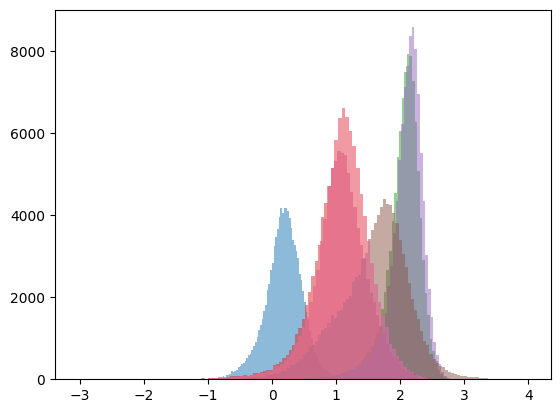

In [99]:
#%% Select data, split into X and y- matrix and exclude scenes for analysis later on

# -- observation
X_sar = df_obs.drop(columns = ['S_sigma0_xi_norm_std', 'S_sigma0_xi_mean', 'wdir'])
# X_scat = df_obs[['U_n', 'incidence_avg', 'energy_dir_range']] 

# -- validation
y_deltaT = np.log10(abs(df_val.tsea_era5-df_val.tair_era5))
y_hlb = np.log10(df_val['hsb_era5']) # FIXME this should be hsb
y_hsb = np.log10(df_val.hlb_era5) # FIXME this should be hlb
y_hbb = np.log10(df_val.hbb_era5)
y_sshf = np.log10(abs(df_val['sshf_era5']))
y_slhf = np.log10(abs(df_val['slhf_era5']))
y_L = np.log10(abs(df_val['L_era5']))
y_bf = np.log10(abs(df_val['hsb_era5'])) # FIXME this should be another variable


# FIXME this should include y_hbb
plt.hist(y_deltaT, bins = 100, alpha = 0.5);
plt.hist(y_hlb, bins = 100, alpha = 0.5)
plt.hist(y_hsb, bins = 100, alpha = 0.5)
plt.hist(y_sshf, bins = 100, alpha = 0.5)
plt.hist(y_slhf, bins = 100, alpha = 0.5)
_ = plt.hist(y_L, bins = 100, alpha = 0.5)
_ = plt.hist(y_bf, bins = 100, alpha = 0.5)

In [100]:
#%% Prepare Machine Learning 
n_trials = 0

result_deltaT = AutomatedRegression(
    y = y_deltaT, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_deltaT_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hlb = AutomatedRegression(
    y = y_hlb, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hlb_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hsb = AutomatedRegression(
    y = y_hsb, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hsb_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_sshf = AutomatedRegression(
    y = y_sshf, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_sshf_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_slhf = AutomatedRegression(
    y = y_slhf, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_slhf_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_L = AutomatedRegression(
    y = y_L, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_L_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_bf = AutomatedRegression(
    y = y_bf, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_bf_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)




In [101]:
#%% Apply the regression
result_deltaT.apply()
result_hlb.apply()
result_hsb.apply()
result_slhf.apply()
result_sshf.apply()
result_L.apply()
result_bf.apply()

[I 2023-10-02 09:41:14,839] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 09:41:14,892] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 09:41:34,689] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________



[I 2023-10-02 09:41:34,900] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 09:42:03,845] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 09:42:03,890] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________



[I 2023-10-02 09:42:18,769] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 09:42:18,814] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________



[I 2023-10-02 09:42:31,335] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 09:42:31,381] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________



[I 2023-10-02 09:42:56,018] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 09:42:56,049] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________



[I 2023-10-02 09:43:11,033] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 09:43:11,075] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________

_________________________
Stacked model overwritten
_________________________



In [102]:
print(result_deltaT.summary['lightgbm_best'][1][0])
print(result_hlb.summary['lightgbm_best'][1][0])
print(result_hsb.summary['lightgbm_best'][1][0])
print(result_slhf.summary['lightgbm_best'][1][0])
print(result_sshf.summary['lightgbm_best'][1][0])
print(result_L.summary['lightgbm_best'][1][0])
print(result_bf.summary['lightgbm_best'][1][0])

0.5304021998698971
0.5211709391992316
0.7944821721874782
0.7753974683291711
0.5444346289092714
0.7828709047742071
0.5211709391992316


In [103]:
print(r2_score(10**result_deltaT.y_test, 10**result_deltaT.y_pred))
print(r2_score(10**result_hlb.y_test, 10**result_hlb.y_pred))
print(r2_score(10**result_hsb.y_test, 10**result_hsb.y_pred))
print(r2_score(10**result_slhf.y_test, 10**result_slhf.y_pred))
print(r2_score(10**result_sshf.y_test, 10**result_sshf.y_pred))
print(r2_score(10**result_L.y_test, 10**result_L.y_pred))
print(r2_score(10**result_bf.y_test, 10**result_bf.y_pred))

0.6028309443343898
0.6923334179056231
0.7752728963773953
0.7615533321645063
0.7250372419675859
0.3162669449345292
0.6923334179056231


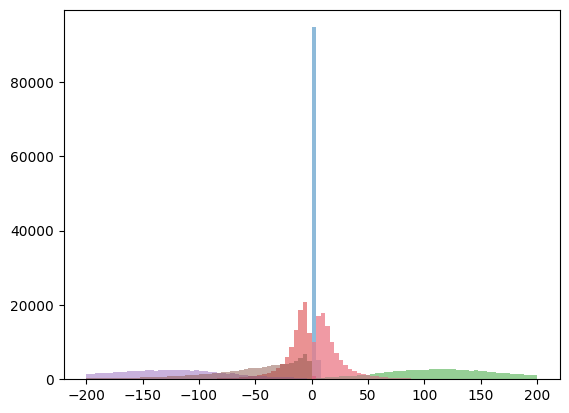

In [ ]:
# -- validation
y_deltaT = df_val.tsea_era5-df_val.tair_era5
y_hlb = df_val['hsb_era5'] # FIXME this should be hsb
y_hsb = df_val.hlb_era5 # FIXME this should be hlb
y_hbb = df_val.hbb_era5
y_sshf = df_val['sshf_era5']
y_slhf = df_val['slhf_era5']
y_L = df_val['L_era5']
y_bf = df_val['hsb_era5']

import matplotlib.pyplot as plt
plt.hist(y_deltaT, bins = 100, alpha = 0.5, range = (-200, 200));
plt.hist(y_hlb, bins = 100, alpha = 0.5, range = (-200, 200))
plt.hist(y_hsb, bins = 100, alpha = 0.5, range = (-200, 200))
plt.hist(y_sshf, bins = 100, alpha = 0.5, range = (-200, 200))
plt.hist(y_slhf, bins = 100, alpha = 0.5, range = (-200, 200))
_ = plt.hist(y_L, bins = 100, alpha = 0.5, range = (-200, 200))
_ = plt.hist(y_bf, bins = 100, alpha = 0.5, range = (-200, 200))

In [69]:
#%% Prepare Machine Learning 
n_trials = 0


result_deltaT = AutomatedRegression(
    y = y_deltaT, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_deltaT_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hlb = AutomatedRegression(
    y = y_hlb, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hlb_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_hsb = AutomatedRegression(
    y = y_hsb, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_hsb_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_sshf = AutomatedRegression(
    y = y_sshf, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_sshf_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_slhf = AutomatedRegression(
    y = y_slhf, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_slhf_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_L = AutomatedRegression(
    y = y_L, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_L_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

result_bf = AutomatedRegression(
    y = y_bf, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = n_trials,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = r2_score,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'maximize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/test_bf_nonlog_v0",
    models_to_optimize = ['lightgbm'], #'catboost', 'xgboost'
    random_state = 42)

In [71]:
#%% Apply the regression
result_deltaT.apply()
result_hlb.apply()
result_hsb.apply()
result_slhf.apply()
result_sshf.apply()
result_L.apply()
result_bf.apply()

[I 2023-10-02 08:20:18,734] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-10-02 08:20:27,925] Trial 6 pruned. 
[I 2023-10-02 08:20:46,915] Trial 7 finished with value: 0.2964382742018713 and parameters: {'scaler': 'standard', 'objective': 'regression', 'max_depth': 5, 'n_estimators': 693, 'max_bin': 255, 'min_gain_to_split': 6.413115275378244, 'lambda_l1': 1.6934490731313353e-08, 'lambda_l2': 9.354548757337708e-08, 'num_leaves': 10, 'feature_fraction': 0.6727693701374023, 'bagging_fraction': 0.382920382968694, 'bagging_freq': 4, 'min_child_samples': 91, 'random_state': 42, 'verbosity': -1, 'transformers': 'quantile_trans', 'n_quantiles': 3100}. Best is trial 1 with value: 0.7284711117101497.
[I 2023-10-02 08:23:13,580] Trial 8 pruned. 
[I 2023-10-02 08:23:21,546] Trial 9 pruned. 
[I 2023-10-02 08:23:39,534] Trial 10 pruned. 
[I 2023-10-02 08:23:42,670] Trial 11 pruned. 
[I 2023-10-02 08:24:00,889] Trial 12 pruned. 
[I 2023-10-02 08:28:42

In [91]:
print(result_deltaT.summary['lightgbm_best'][1][0])
print(result_hlb.summary['lightgbm_best'][1][0])
print(result_hsb.summary['lightgbm_best'][1][0])
print(result_slhf.summary['lightgbm_best'][1][0])
print(result_sshf.summary['lightgbm_best'][1][0])
print(result_L.summary['lightgbm_best'][1][0])
print(result_bf.summary['lightgbm_best'][1][0])

0.6306286166196807
0.7224611548005047
0.7709947419452237
0.7605642793282399
0.7527592970814256
0.38102129344972263
0.7224611548005047


In [88]:
print(r2_score(np.log10(abs(result_deltaT.y_test)), np.log10(abs(result_deltaT.y_pred))))
print(r2_score(np.log10(abs(result_hlb.y_test)), np.log10(abs(result_hlb.y_pred))))
print(r2_score(np.log10(abs(result_hsb.y_test)), np.log10(abs(result_hsb.y_pred))))
print(r2_score(np.log10(abs(result_slhf.y_test)), np.log10(abs(result_slhf.y_pred))))
print(r2_score(np.log10(abs(result_sshf.y_test)), np.log10(abs(result_sshf.y_pred))))
print(r2_score(np.log10(abs(result_L.y_test)), np.log10(abs(result_L.y_pred))))
print(r2_score(np.log10(abs(result_bf.y_test)), np.log10(abs(result_bf.y_pred))))

0.49851243102299025
0.4357760379248803
0.709108538023375
0.6787608724233571
0.4979007124910182
0.7004223982760727
0.4357760379248803


In [113]:
to_log = [0.5304021998698971, 0.5211709391992316, 0.7944821721874782, 0.7753974683291711, 0.5444346289092714, 0.7828709047742071, 0.5211709391992316]
to_log_unlog = [0.6028309443343898, 0.6923334179056231, 0.7752728963773953, 0.7615533321645063, 0.7250372419675859, 0.3162669449345292, 0.6923334179056231]
to_non = [0.6306286166196807, 0.7224611548005047, 0.7709947419452237, 0.7605642793282399, 0.7527592970814256, 0.38102129344972263, 0.7224611548005047]
to_non_power = [0.49851243102299025, 0.4357760379248803, 0.709108538023375, 0.6787608724233571, 0.4979007124910182, 0.7004223982760727, 0.4357760379248803]

pd.DataFrame(data = np.array([to_log, to_log_unlog, to_non, to_non_power]).T, 
             columns = ["log", "log_inv_log", "none", "none_power"], 
             index=["delta_T", "shf_coare", "lhf_coare", "lhf_era5", "shf_era5", "L_coare", "buoyancy_coare"])

,log,log_inv_log,none,none_power
delta_T,0.530402,0.602831,0.630629,0.498512
shf_coare,0.521171,0.692333,0.722461,0.435776
lhf_coare,0.794482,0.775273,0.770995,0.709109
lhf_era5,0.775397,0.761553,0.760564,0.678761
shf_era5,0.544435,0.725037,0.752759,0.497901
L_coare,0.782871,0.316267,0.381021,0.700422
buoyancy_coare,0.521171,0.692333,0.722461,0.435776


Text(0.5, 1.0, 'log Obukhov length coare')

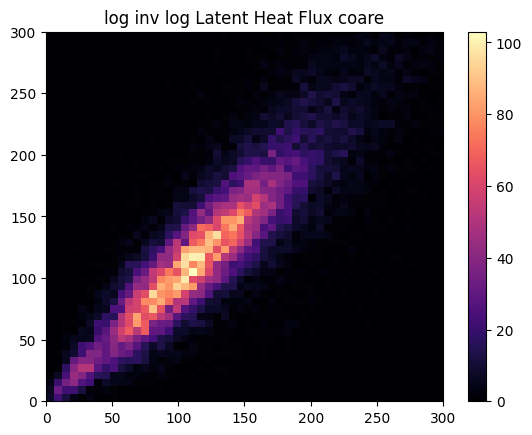

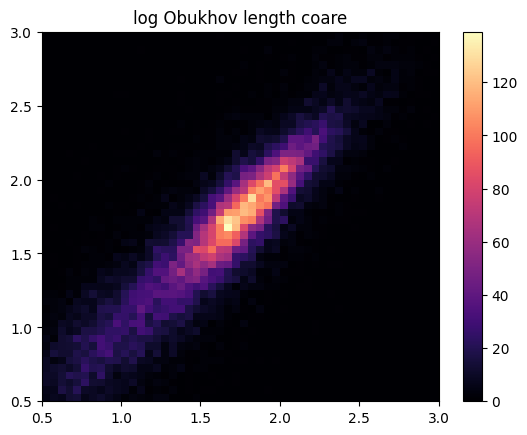

In [135]:
# NOTE these figures are from "log" and "log_inv_log"
plt.figure(); plt.hist2d(np.ravel(10**result_hsb.y_pred), np.ravel(10**result_hsb.y_test), bins=(50, 50), cmap="magma", range = [(0, 300), (0,300)]); plt.colorbar(); plt.title("log inv log Latent Heat Flux coare")
plt.figure(); plt.hist2d(np.ravel(result_L.y_pred), np.ravel(result_L.y_test), bins=(50, 50), cmap="magma", range = [(0.5, 3), (0.5, 3)]); plt.colorbar(); plt.title("log Obukhov length coare")